In [17]:
!pip install --upgrade pip
!pip uninstall protobuf --yes
!pip install --upgrade "protobuf<=3.19.4"
!pip install transformers emoji datasets
!pip install huggingface_hub

Found existing installation: protobuf 3.19.4
Uninstalling protobuf-3.19.4:
  Successfully uninstalled protobuf-3.19.4
  Using cached protobuf-3.19.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf 23.6.1 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.19.4 which is incompatible.
cuml 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
dask-cudf 23.6.1 r

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, TFAutoModel, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import TFAutoModelForSequenceClassification, TFAutoModelForMultipleChoice
from transformers import BertTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer as TFTokenizer
import emoji
#from datasets import Dataset
#import torch
#from torch.utils.data import DataLoader

from transformers import BertTokenizer, TFBertModel
import tensorflow_hub as hub
#import tokenization
tf.random.set_seed(8)
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


At the top menu, click on **Add-ons**->**Secret** Click on **Add a new secret** and then create a new Secret key with label **wandb_api_key** and your wandb secret key on **value**

In [19]:
import wandb
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load dataset and split train into training and validation

In [20]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv").fillna('')
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv").fillna('')
train_df.head()

,id,keyword,location,text,target
0,1,,,Our Deeds are the Reason of this #earthquake M...,1
1,4,,,Forest fire near La Ronge Sask. Canada,1
2,5,,,All residents asked to 'shelter in place' are ...,1
3,6,,,"13,000 people receive #wildfires evacuation or...",1
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1


## Clean text to remove things like URLs, Emojis, Hashtags, etc

In [21]:
import re

# Taken from https://stackoverflow.com/a/33417311
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

# Keep only alphabetic characters
non_alpha_pattern = re.compile('[^a-zA-Z]')

# Replace abbreviations with full text
abbreviations = {
    r'can\'t': 'cannot',
    r'won\'t': 'will not',
    r'wouldn\'t': 'would not',
    r'\'ll': ' will',
    r'n\'t': ' not',
    r'\'re': ' are',
    r'\'s': ' is',
    r'\'d': ' would',
    r'\'t': ' not',
    r'\'ve': ' have',
    r'\'m': ' am',
}

def clean_text(text):
    text = re.sub(r'http\S+', '<URL>', text) # Remove URLs
    
    text = emoji_pattern.sub(r'', text) # Remove emojis' unicodes
    
    text = emoji.demojize(text) # Convert emojis to code :) -> :smiley face:
    
    #text = re.sub(r':\S+', '', text) # Remove text after :
    text = re.sub(':[^>]+:', '', text) # remove text between two : (e.g: :smiley face:)

    # Remove special vocals
    text = re.sub(r'[àáâãäå]', 'a', text)
    text = re.sub(r'[èéêë]', 'e', text)
    text = re.sub(r'[ìíîï]', 'i', text)
    text = re.sub(r'[òóôõö]', 'o', text)
    text = re.sub(r'[ùúûü]', 'u', text)
    
    # Remove twitter mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    
    # Remove abbreviations
    for abbrev, replace_text in abbreviations.items():
        text = re.sub(abbrev, replace_text, text)
        
    text = ''.join([x for x in text if x.isalpha() or x == ' ']) # remove all non-alpha characters
    
    text = text.strip()
    
    text = text.lower()

    return text


train_df.text = train_df.text.apply(lambda x: clean_text(x))
test_df.text = test_df.text.apply(lambda x: clean_text(x))

train_df.head(10)

,id,keyword,location,text,target
0,1,,,our deeds are the reason of this earthquake ma...,1
1,4,,,forest fire near la ronge sask canada,1
2,5,,,all residents asked to ishelter in place are ...,1
3,6,,,people receive wildfires evacuation orders in ...,1
4,7,,,just got sent this photo from ruby alaska as s...,1
5,8,,,rockyfire update california hwy closed in bo...,1
6,10,,,flood disaster heavy rain causes flash floodin...,1
7,13,,,i am on top of the hill and i can see a fire i...,1
8,14,,,there is an emergency evacuation happening now...,1
9,15,,,i am afraid that the tornado is coming to our ...,1


## Take all text from training and testing datasets, and then tokenize it using TF's Tokenizer to remove all special characters and convert everything to lowercase

In [22]:
all_text = train_df.text.tolist() + test_df.text.tolist()

# Tokenizer
tf_tokenizer = TFTokenizer(oov_token = '<OOV>')
tf_tokenizer.fit_on_texts(all_text)
sequences = tf_tokenizer.texts_to_sequences(all_text)
max_len = max([len(seq) for seq in sequences])
print(f'Found {len(tf_tokenizer.word_index)} unique words and longest sentence has {max_len} words')

Found 18595 unique words and longest sentence has 32 words


## Now replace text in dataset with final cleaned text from Tokenizer

In [23]:
token_to_word = {token: word for (word, token) in tf_tokenizer.word_index.items()}
def sequences_to_texts(sequences):
    words = []
    for token in sequences:
        if len(token) > 0:
            words.append(token_to_word[token[0]])
        else:
            words.append('<OOV>')
            
    return ''.join(words).replace('<OOV>', ' ')

print("Example:")
print("Input:", all_text[0])
sequences = tf_tokenizer.texts_to_sequences(all_text[0])
rec_text = sequences_to_texts(sequences)
print("Output:", rec_text)

Example:
Input: our deeds are the reason of this earthquake may allah forgive us all
Output: our deeds are the reason of this earthquake may allah forgive us all


In [24]:
def replace_text(text):
    sequences = tf_tokenizer.texts_to_sequences(text)
    return sequences_to_texts(sequences)

train_df.text = train_df.text.apply(lambda x: replace_text(x))
test_df.text = test_df.text.apply(lambda x: replace_text(x))

train_df.head()

,id,keyword,location,text,target
0,1,,,our deeds are the reason of this earthquake ma...,1
1,4,,,forest fire near la ronge sask canada,1
2,5,,,all residents asked to ishelter in place are ...,1
3,6,,,people receive wildfires evacuation orders in ...,1
4,7,,,just got sent this photo from ruby alaska as s...,1


## Load Pre-trained model

In [25]:
%%time
try: 
    del bert_layer
except:
    pass

bert_layer = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

CPU times: user 1.58 s, sys: 111 ms, total: 1.69 s
Wall time: 1.77 s


In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Bert encoder

In [27]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [28]:
X_train = bert_encode(train_df['location'] + ' ' + train_df['keyword'] + ' ' + train_df['text'], tokenizer, max_len=60)
X_test = bert_encode(test_df['location'] + ' ' + test_df['keyword'] + ' ' + test_df['text'], tokenizer, max_len=60)
y_train = train_df.target.values

## Custom model

In [29]:
class CustomModel(tf.keras.models.Model):
    def __init__(self, bert_layer, max_len = 512):
        super().__init__()
        self.bert_layer = bert_layer
        self.max_len = max_len
        
    def build(self):
        input_ids = tf.keras.layers.Input(shape = (self.max_len, ), dtype = 'int32', name = 'input_words')
        attention_masks = tf.keras.layers.Input(shape = (self.max_len,), dtype='int32', name='input_mask')
        segments = tf.keras.layers.Input(shape = (self.max_len,), dtype='int32', name='segment_ids')
        
        # Bert layer
        bert_output = self.bert_layer([input_ids, attention_masks, segments], output_hidden_states = True, output_attentions = True)
        output = bert_output['pooler_output']
        #output = tf.keras.layers.Dropout(0.5)(output)
        #output = tf.keras.layers.BatchNormalization()(output)
        output = tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1(0.001))(output)
        #output = tf.keras.layers.Dropout(0.5)(output)
        #output = tf.keras.layers.Dense(16, activation = 'relu')(output)
        output = tf.keras.layers.Dense(1, activation = 'sigmoid')(output)
        
        model = tf.keras.models.Model(inputs = [input_ids, attention_masks, segments], outputs = output)
        return model

## Load pre-trained model

In [30]:
model = CustomModel(bert_layer, max_len = 60)
model = model.build()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_words (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 60)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_words[0][0]',            
                                thPoolingAndCrossAt               'input_mask[0][0]',       

## TF model callbacks

In [31]:
def scheduler(epoch, lr):
    return lr * 0.5

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights = True)
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)
early_stopping_val_acc = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, restore_best_weights = True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor = 'val_loss', save_best_only = True)

model_callbacks = [
    #lr_scheduler,
    #early_stopping_loss,
    #early_stopping_val_loss,
    #early_stopping_val_acc,
    checkpoint
]

## Compile and fit

In [32]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs=10,
    batch_size = 16,
    callbacks = model_callbacks
)

Epoch 1/10
381/381 [==============================] - 127s 215ms/step - loss: 1.5211 - accuracy: 0.7924 - val_loss: 1.4389 - val_accuracy: 0.8201
Epoch 2/10
381/381 [==============================] - 70s 184ms/step - loss: 1.3852 - accuracy: 0.8586 - val_loss: 1.4217 - val_accuracy: 0.8234
Epoch 3/10
381/381 [==============================] - 69s 181ms/step - loss: 1.2818 - accuracy: 0.8929 - val_loss: 1.4119 - val_accuracy: 0.8240
Epoch 4/10
381/381 [==============================] - 66s 173ms/step - loss: 1.1886 - accuracy: 0.9245 - val_loss: 1.4903 - val_accuracy: 0.7991
Epoch 5/10
381/381 [==============================] - 66s 173ms/step - loss: 1.1004 - accuracy: 0.9458 - val_loss: 1.5045 - val_accuracy: 0.7866
Epoch 6/10
381/381 [==============================] - 65s 172ms/step - loss: 1.0360 - accuracy: 0.9612 - val_loss: 1.4997 - val_accuracy: 0.8083
Epoch 7/10
381/381 [==============================] - 66s 172ms/step - loss: 0.9760 - accuracy: 0.9713 - val_loss: 1.6672 - val_a

## Plot metrics

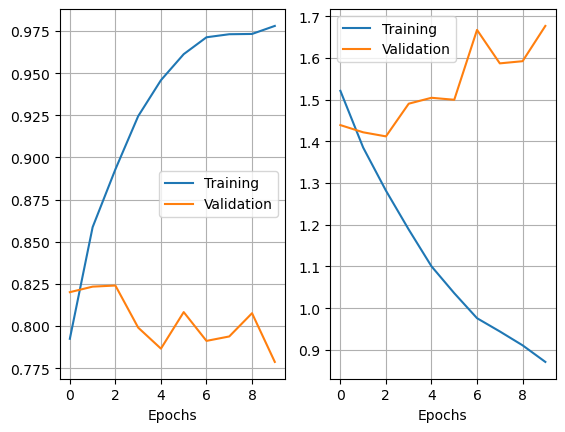

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)

axes[0].plot(history.history['accuracy'], label = 'Training')
axes[0].plot(history.history['val_accuracy'], label = 'Validation')
axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epochs')

axes[1].plot(history.history['loss'], label = 'Training')
axes[1].plot(history.history['val_loss'], label = 'Validation')
axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epochs')

plt.show()

## Predict

In [34]:
model.load_weights('model.h5')

preds = model.predict(X_test).round().astype(int)

102/102 [==============================] - 12s 89ms/step


## Prepare submission

In [35]:
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission.target = preds

submission.to_csv('submission.csv', index = False)

## Save model

In [36]:
# saved_model_name = MODEL_NAME.replace('/', '-') + '-disaster-tweets'
# model.save(saved_model_name)
# model.save_weights(saved_model_name + '_weights', save_format="tf")

In [37]:
# model.save_weights(saved_model_name + '_weights', save_format="tf")